In [1]:
library(tidyverse)
library(magrittr)
library(patchwork)

theme_set(theme_bw(base_size=12) + theme(panel.grid=element_blank(), 
                             panel.border=element_blank(), 
                             axis.line = element_line(arrow=arrow(length=unit(2, "mm"))),
                             strip.text = element_text(size=12),
                             strip.background=element_blank()))


library(SingleCellExperiment)
library(multisce)
library(scutility)

library(ggpubr)

seed <- 124
set.seed(seed)

Warning message:
“package ‘tibble’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘forcats’ was built under R version 4.3.2”
Warning message:
“package ‘lubridate’ was built under R version 4.3.2”
── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks st

In [2]:
sce <- multisce_load(path=here::here("data", "multisce", "skin"), main_name="RNA", reduceddim_include="umap", metadata_include="colors")
sce

Loading RNA from /home/tbb/git/CTCL_KC_HLAII/data/multisce/skin/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_KC_HLAII/data/multisce/skin/coldata.rds

Loading colors from /home/tbb/git/CTCL_KC_HLAII/data/multisce/skin/metadata/colors.rds

Loading umap from /home/tbb/git/CTCL_KC_HLAII/data/multisce/skin/reducedDim/umap.rds



class: SingleCellExperiment 
dim: 36601 229041 
metadata(2): multisce_path colors
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(229041): AAACCTGAGACAAGCC-1_1 AAACCTGAGCTAGTTC-1_1 ...
  TTTGTCATCTGATACG-1_39 TTTGTCATCTTCGGTC-1_39
colData names(208): run sum ... cell_type.2 cell_lineage
reducedDimNames(1): umap
mainExpName: RNA
altExpNames(0):

In [ ]:
metadata <- read.table(here::here("data", "CTCL_MF_atlas_samples.tsv"), sep="\t", header=TRUE)
metadata %<>% group_by(run) %>% summarize(across(dplyr::everything(), function(x)x[1])) %>% column_to_rownames("run")

In [4]:
columns <- c("chemistry", "lesion", "location", "CTCL_stage", "TNMB", "age", "sex", "sample", "study")

colData(sce) %<>% .[, !colnames(.) %in% columns]
colData(sce) %<>% cbind(metadata[as.character(.$run), columns])

In [5]:
sce$CTCL_stage %<>% gsub("IVA1", "IVA", .)

In [6]:
sce$lesional <- "CTCL"
sce$lesional[sce$lesion == "Healthy"] <- "Healthy"

sce$lesional %<>% factor(levels=c("Healthy", "CTCL"))

metadata(sce)$colors$lesional <- c("Healthy"="#3333CC", "CTCL"="#CC3333")

In [7]:
sce$cell_lineage %<>% fct_recode("Keratinocytes"="Epithelial")

In [8]:
plots <- list()

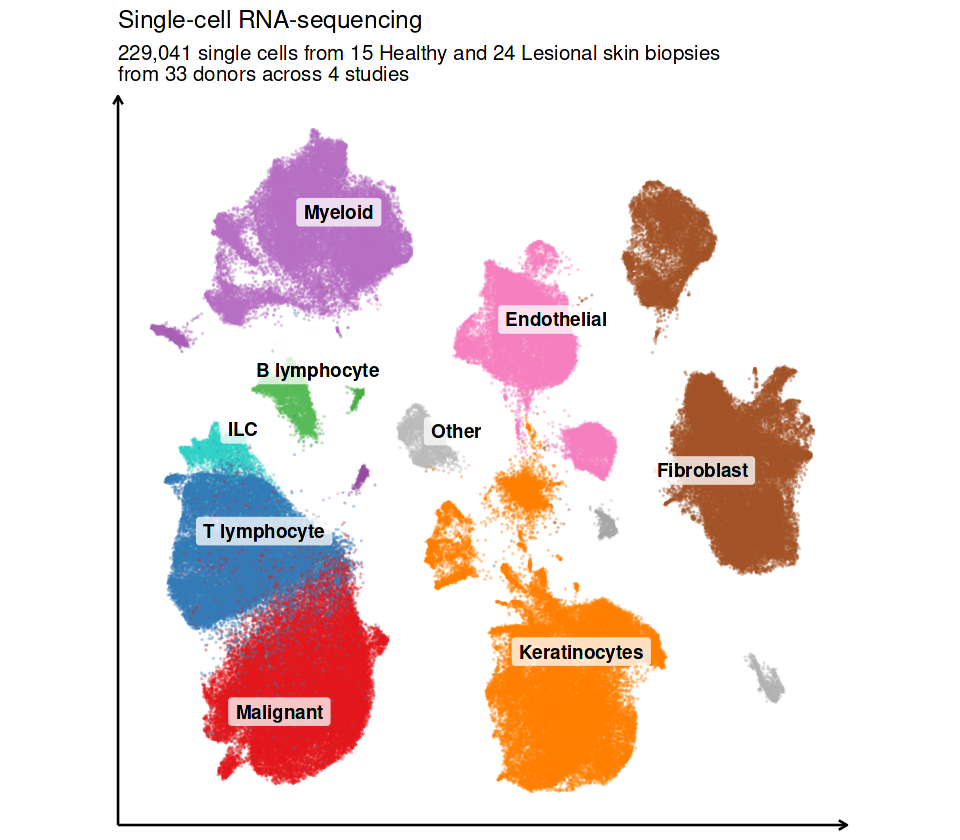

In [9]:
plots$UMAP <- plot_dimred(sce, dimred="umap", colour_by="cell_type", text_by="cell_lineage", 
            shuffle=TRUE, rasterise=TRUE,
            scale_color=scale_color_manual(values=metadata(sce)$colors$cell_type), 
            point_size=0.1, point_alpha=0.25) + 
    theme(aspect.ratio=1, legend.position="none",
          axis.ticks=element_blank(), 
          axis.title=element_blank(), 
          axis.text=element_blank()) + 
    labs(title="Single-cell RNA-sequencing", subtitle="229,041 single cells from 15 Healthy and 24 Lesional skin biopsies\nfrom 33 donors across 4 studies")

options(repr.plot.width=8, repr.plot.height=7)
plots$UMAP

In [10]:
sce$KC_HLADRA <- logcounts(sce)["HLA-DRA", ]
sce$KC_HLADRA[sce$cell_type != "Keratinocytes"] <- NA

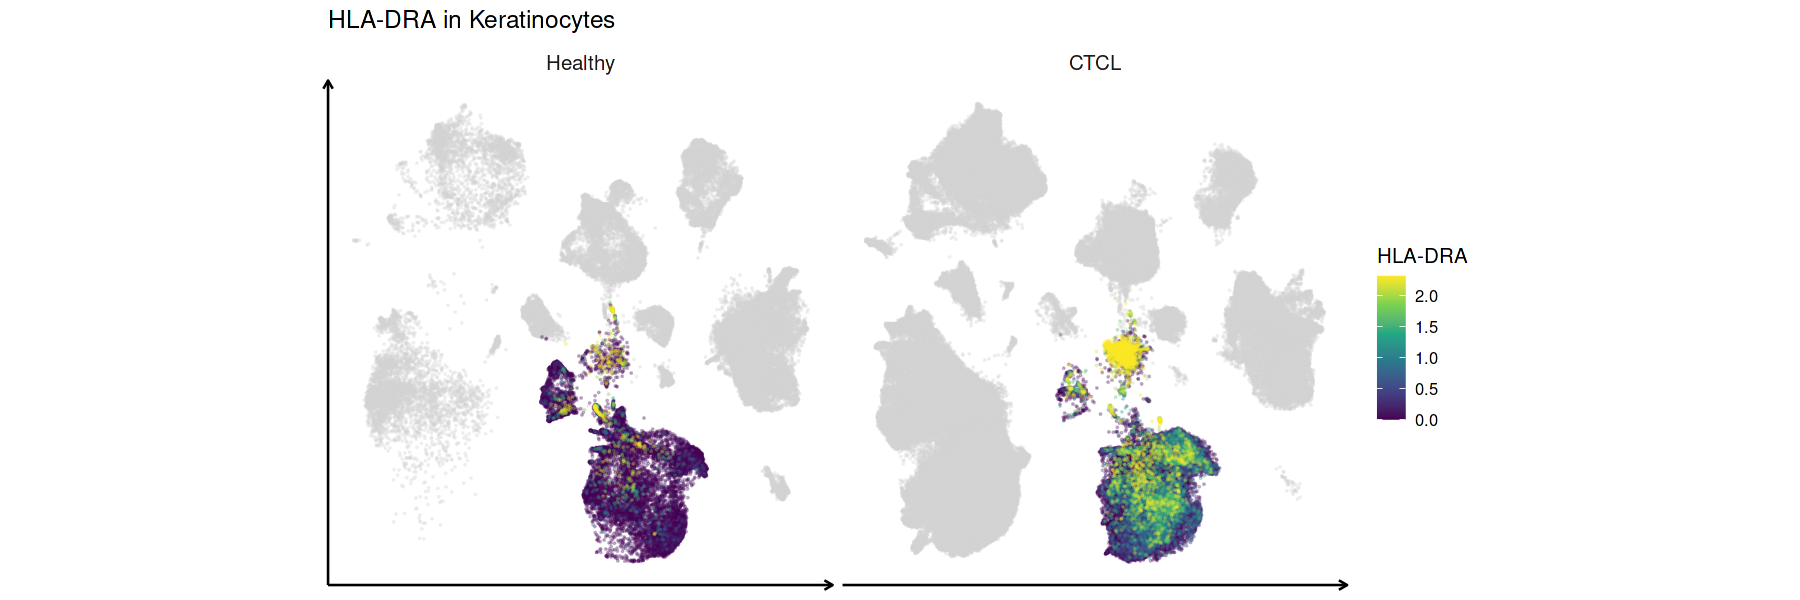

In [13]:
plots$KC_UMAP <- plot_dimred(sce, dimred="umap", colour_by="KC_HLADRA", features_add="lesional",
            order=TRUE, max.cutoff='q95', rasterise=TRUE,
            point_size=0.25, point_alpha=0.25) + 
    facet_wrap(~ lesional, nrow=1) + 
    theme(aspect.ratio=1, 
          axis.ticks=element_blank(), 
          axis.title=element_blank(), 
          axis.text=element_blank()) + 
    labs(title="HLA-DRA in Keratinocytes", color="HLA-DRA")

options(repr.plot.width=15, repr.plot.height=5)
plots$KC_UMAP

`summarise()` has grouped output by 'study', 'run', 'lesional', 'CTCL_stage'. You can override using the `.groups` argument.
Warning message:
“The dot-dot notation (`..p.format..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(p.format)` instead.”


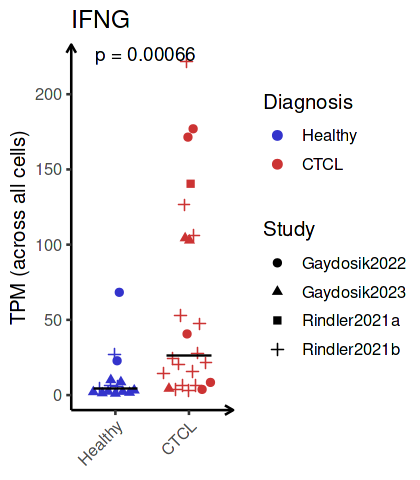

In [13]:
gene <- "IFNG"
data_plot_IFNG <- colData(sce)[, c("run", "lesional", "donor", "cell_type", "lesion", "CTCL_stage", "study", "sum")] %>% as.data.frame() %>% rownames_to_column("BC") %>% 
    cbind(data.frame(GOI=counts(sce)[gene, .$BC]))

data_plot_IFNG %<>% mutate(total=sum) %>% 
    group_by(study, run, lesional, CTCL_stage) %>% mutate(total=sum(total)) %>% 
    group_by(study, run, lesional, CTCL_stage, total) %>% summarize(GOI=sum(GOI)) %>% 
    mutate(tpm=GOI/(total/10^6))

plots$IFNG <- data_plot_IFNG %>% 
    ggplot(aes(x=lesional, y=tpm)) +
        ggbeeswarm::geom_quasirandom(aes(color=lesional, shape=study), size=2) + 
        stat_summary(fun="median", linewidth=0.2, geom="crossbar", width=0.6) +
        stat_compare_means(method="wilcox.test", aes(label = paste0("p = ", ..p.format..))) + 
        scale_color_manual(values=metadata(sce)$colors$lesional) + 
        theme(legend.position="right", 
              axis.title.x=element_blank(), 
              axis.text.x=element_text(angle=45, hjust=1)) + 
        labs(title=gene, y="TPM (across all cells)", color="Diagnosis", shape="Study")

options(repr.plot.width=3.5, repr.plot.height=4)
plots$IFNG

In [ ]:
marker <- "KRT1"
plots$KRT1_UMAP <- plot_dimred(sce, dimred="umap", colour_by=marker, rasterise=TRUE,
            shuffle=TRUE, max.cutoff='q95', 
            point_size=0.25, point_alpha=0.25) + 
    theme(aspect.ratio=1, legend.position="none", 
          axis.ticks=element_blank(), 
          axis.title=element_blank(), 
          axis.text=element_blank()) + 
    labs(title=marker)

In [ ]:
marker <- "KRT14"
plots$KRT14_UMAP <- plot_dimred(sce, dimred="umap", colour_by=marker, rasterise=TRUE,
            shuffle=TRUE, max.cutoff='q95', 
            point_size=0.25, point_alpha=0.25) + 
    theme(aspect.ratio=1, legend.position="none", 
          axis.ticks=element_blank(), 
          axis.title=element_blank(), 
          axis.text=element_blank()) + 
    labs(title=marker)

`summarise()` has grouped output by 'study', 'run', 'lesional'. You can override using the `.groups` argument.


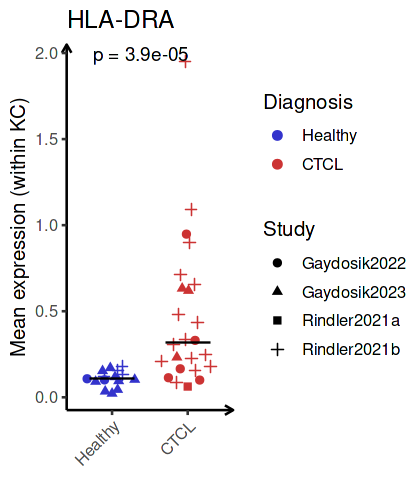

In [14]:
gene <- "HLA-DRA"
data_plot_HLA <- colData(sce)[, c("run", "lesional", "donor", "cell_type", "lesion", "CTCL_stage", "study", "sum")] %>% as.data.frame() %>% rownames_to_column("BC") %>% 
    cbind(data.frame(GOI=logcounts(sce)[gene, .$BC]))

data_plot_HLA %<>% 
    filter(cell_type=="Keratinocytes") %>% 
    group_by(study, run, lesional, CTCL_stage) %>% summarize(GOI=mean(GOI))

plots$HLA_DRA <- data_plot_HLA %>% 
    ggplot(aes(x=lesional, y=GOI)) +
        ggbeeswarm::geom_quasirandom(aes(color=lesional, shape=study), size=2) + 
        stat_summary(fun = "median", linewidth=0.2, geom="crossbar", width=0.6) +
        stat_compare_means(method="wilcox.test", aes(label = paste0("p = ", ..p.format..))) + 
        scale_color_manual(values=metadata(sce)$colors$lesional) + 
        theme(legend.position="right", 
              axis.title.x=element_blank(), 
              axis.text.x=element_text(angle=45, hjust=1)) + 
        labs(title=gene, y="Mean expression (within KC)", color="Diagnosis", shape="Study")

options(repr.plot.width=3.5, repr.plot.height=4)
plots$HLA_DRA

Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Joining, by = c("study", "run", "lesional", "CTCL_stage")
Warning message:
“`stat(r.squared)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.squared)` instead.”


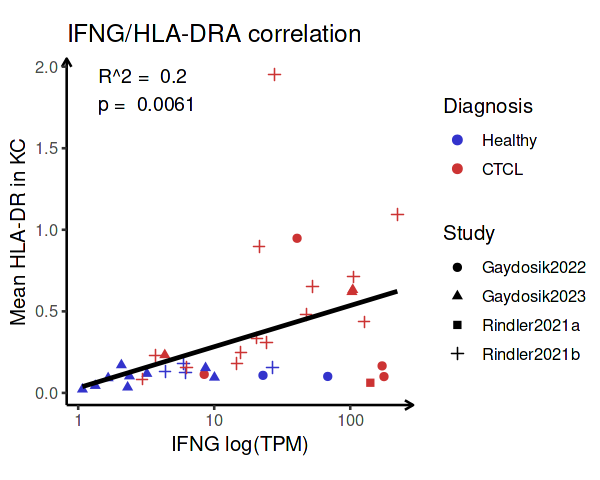

In [27]:
library(ggpmisc)

plots$corr <- data_plot_IFNG %>% select(-GOI) %>% left_join(data_plot_HLA) %>% 
    ggplot(aes(x=tpm, y=GOI)) + 
        geom_point(aes(shape=study, color=lesional), size=2) + 
        scale_x_continuous(trans="log10") + 
        #scale_y_continuous(trans="log10") + 
        stat_poly_line(color="black", se=FALSE) +
        stat_fit_glance(
          method = "lm",
          geom = "text",
          aes(label = paste("R^2 = ", signif(stat(r.squared), digits = 2),
                            "\np = ", signif(stat(p.value), digits = 2))),
          label.x = "left", label.y = "top", hjust=0, 
          size = 4
        ) + 
        scale_color_manual(values=metadata(sce)$colors$lesional) + 
        theme(aspect.ratio=1) + 
        labs(title="IFNG/HLA-DRA correlation", x="IFNG log(TPM)", y="Mean HLA-DR in KC", color="Diagnosis", shape="Study")
        
options(repr.plot.width=5, repr.plot.height=4)
plots$corr

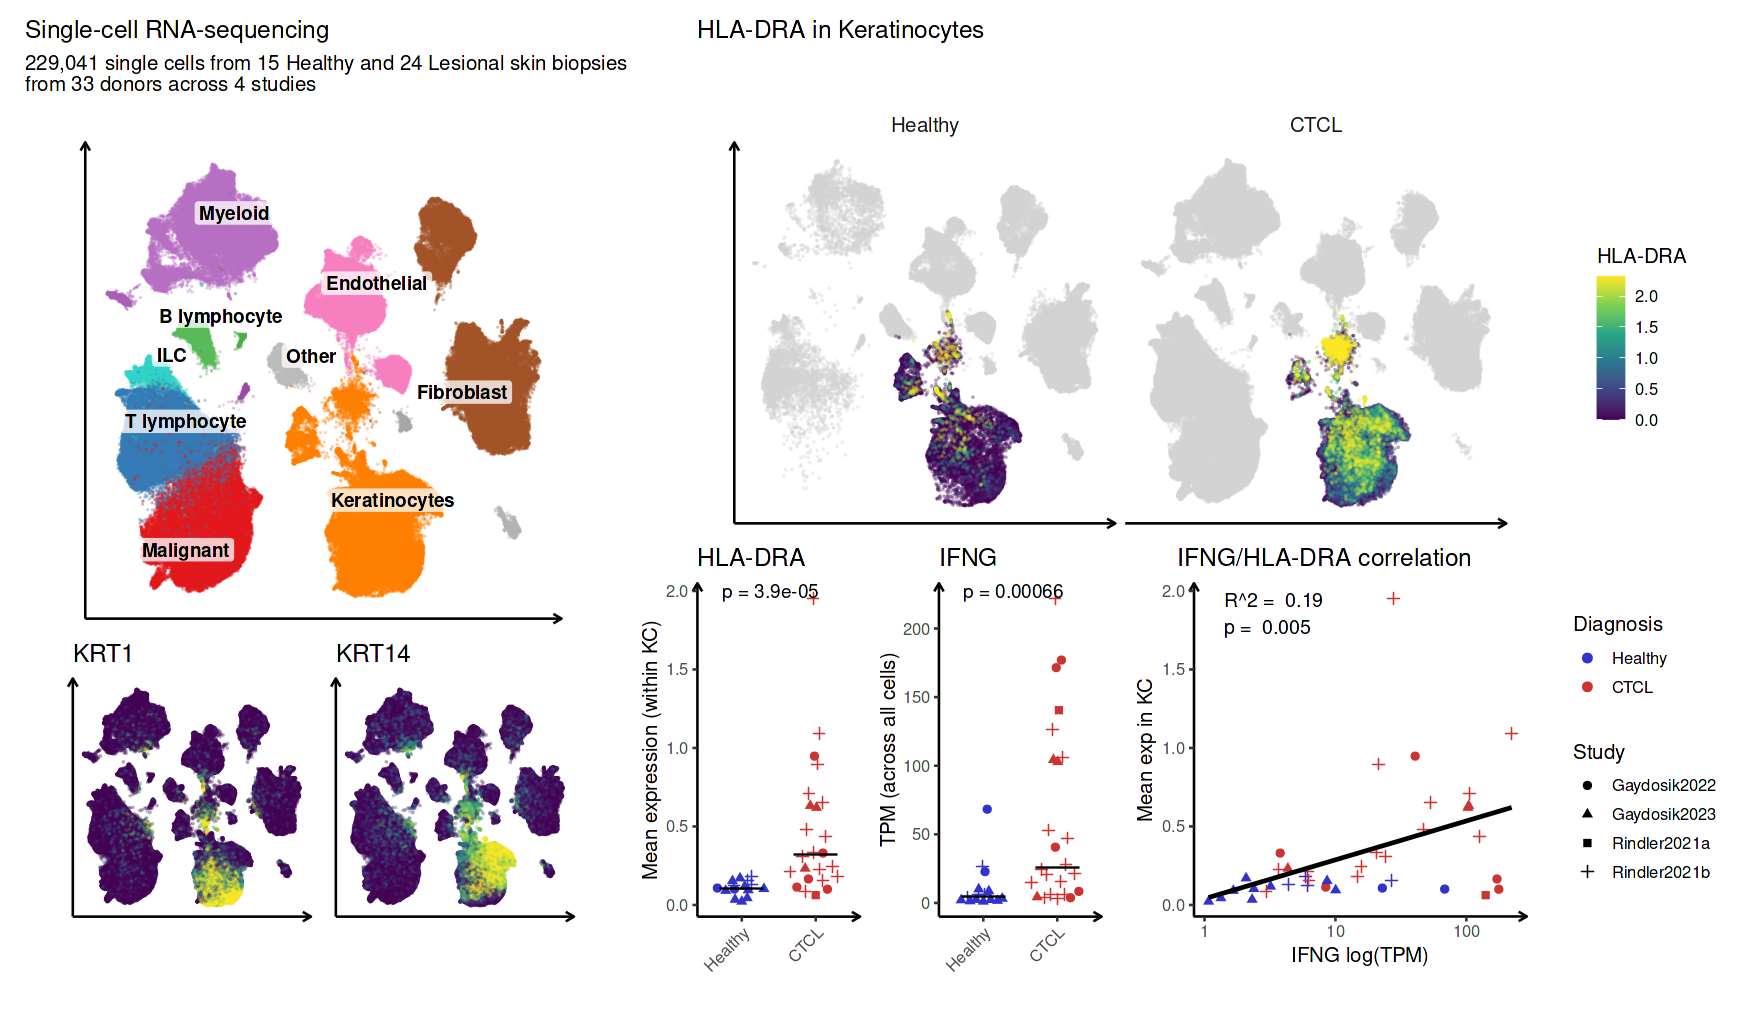

In [17]:
widths <- c(2,2,4.5)
heights <- c(4,3.5)

plot <- wrap_plots(wrap_plots(plots$UMAP, 
                      wrap_plots(plots$KRT1_UMAP, plots$KRT14_UMAP, nrow=1), 
                      ncol=1, heights=c(2,1)),
           wrap_plots(plots$KC_UMAP, 
                      wrap_plots(plots$HLA_DRA, plots$IFNG, plots$corr, widths=widths, nrow=1, guides="collect"), 
                      ncol=1, heights=heights),
           nrow=1, widths=c(6,sum(widths)))

plot %>% 
    ggsave(filename=here::here("figures", "scRNAseq_combined.pdf"),
           device="pdf",
           width=sum(widths)+6, height=sum(heights)+1)

options(repr.plot.width=sum(widths)+6, repr.plot.height=sum(heights)+1)
plot

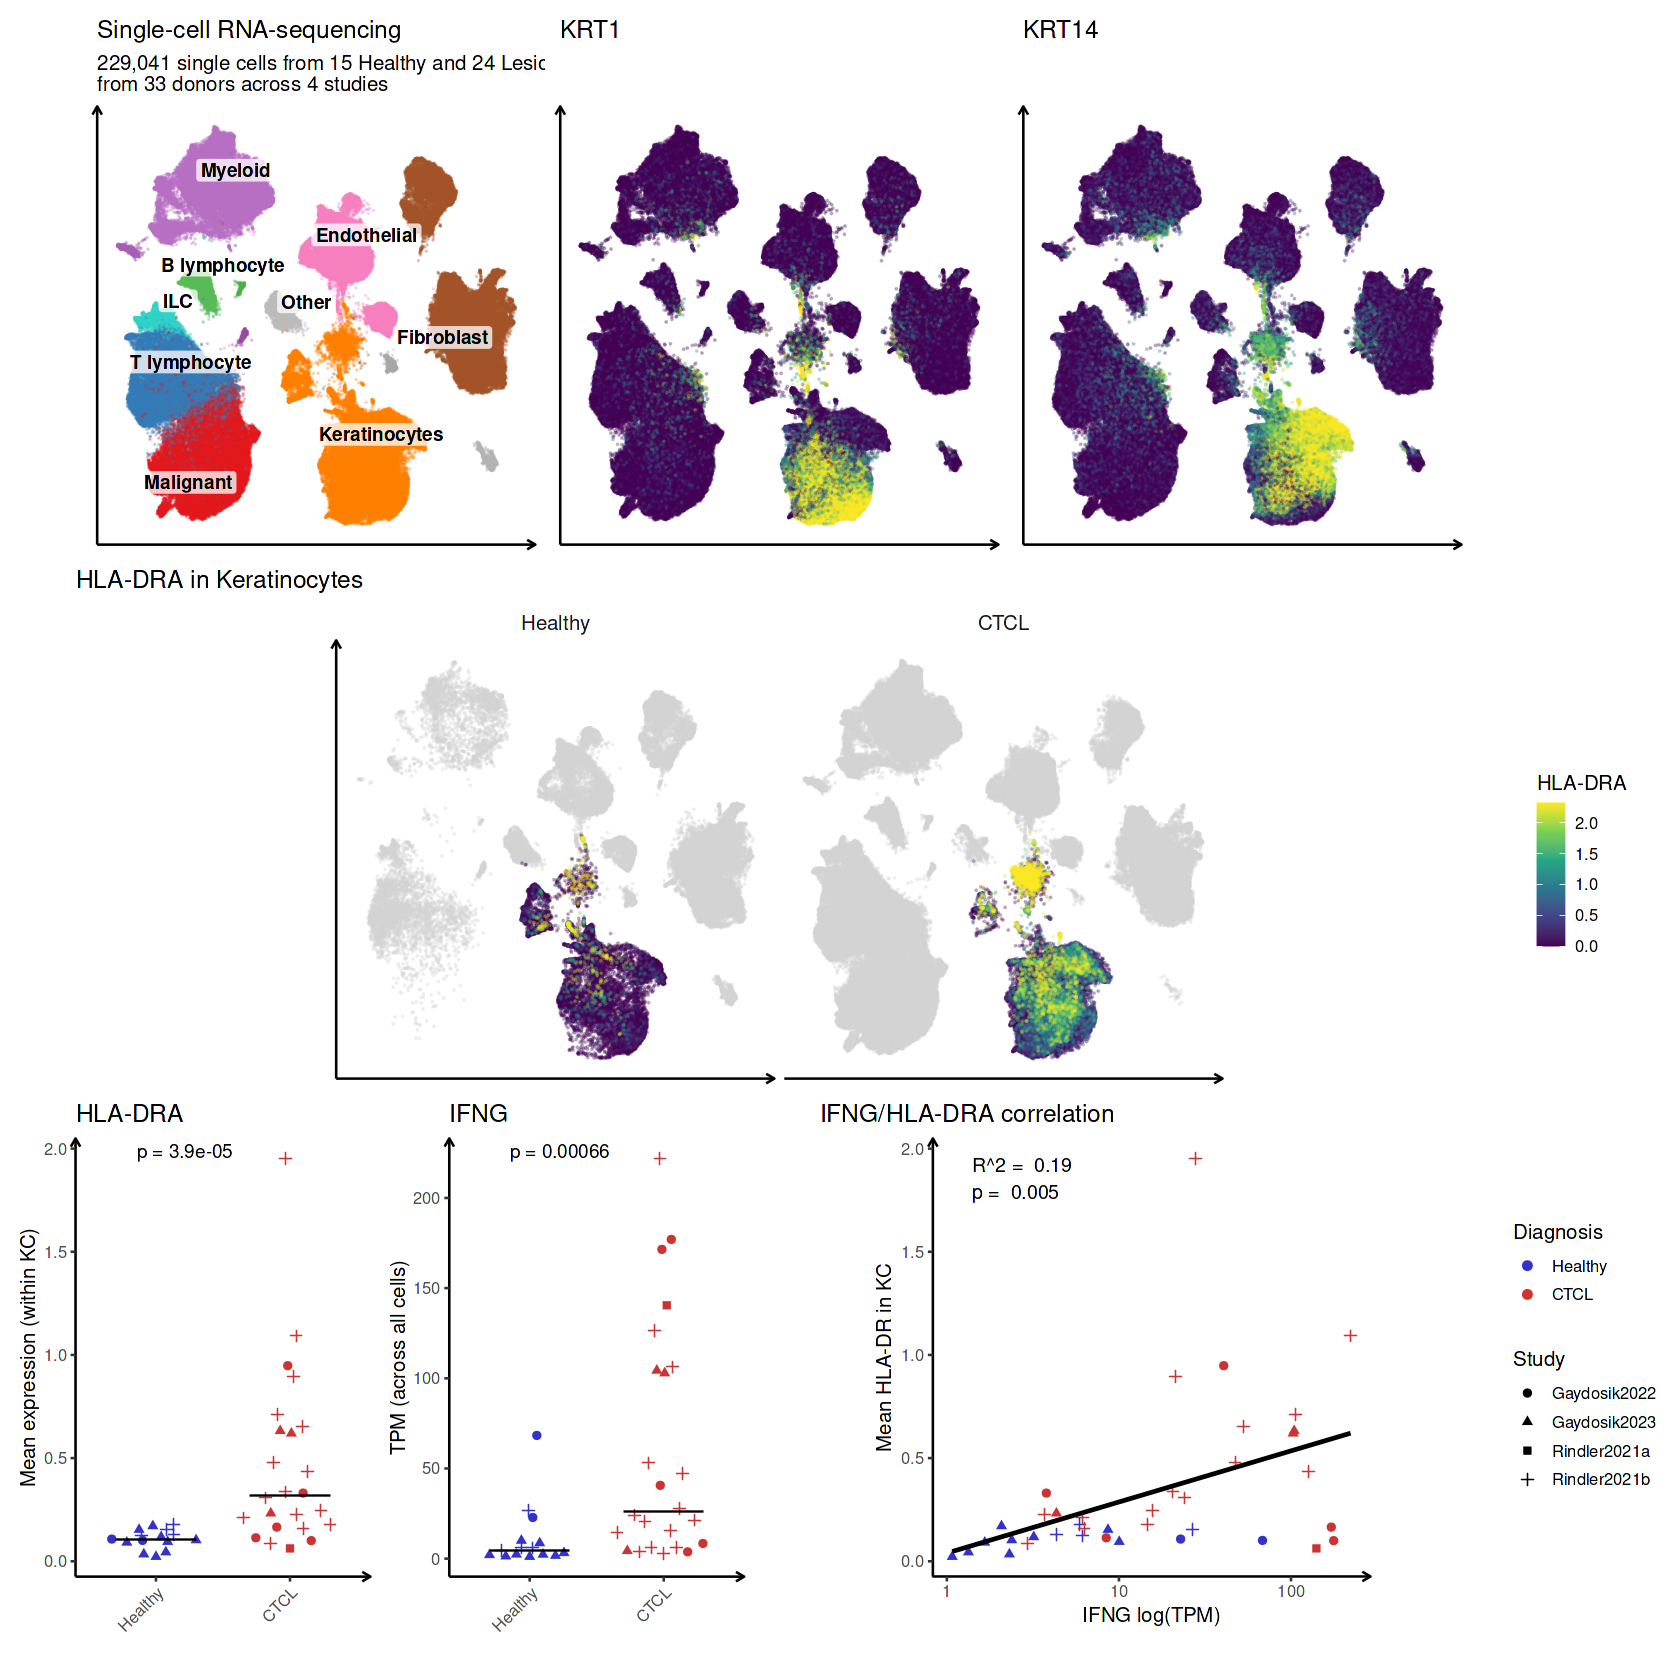

In [37]:
widths <- c(2,2,4.5)
heights <- c(4,3.5)

plot <- wrap_plots(wrap_plots(plots$UMAP, plots$KRT1_UMAP, plots$KRT14_UMAP, nrow=1),
                   plots$KC_UMAP,
                   wrap_plots(plots$HLA_DRA, plots$IFNG, plots$corr, widths=widths, nrow=1, guides="collect"), 
                   ncol=1)

plot %>% 
    ggsave(filename=here::here("figures", "scRNAseq_combined_tall.pdf"),
           device="pdf",
           width=12, height=12)

options(repr.plot.width=14, repr.plot.height=14)
plot